This notebook generates the smooth and adversarial experiment results.

Each experiment is identified by an `EXP_IDX`. The smooth experiment uses `EXP_IDX = 3` and the adversarial experiment uses `EXP_IDX = 5`.

In [1]:
from adaFuncCI.data_generation import unfoldingGenerator
from adaFuncCI.utils import int_cover, find_cis
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from statsmodels.stats.proportion import proportion_confint
from tqdm.notebook import tqdm

# customize plotting settings
matplotlib.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 20})
plt.rcParams['text.usetex'] = True

# Define the LaTeX preamble to include multiple packages
plt.rcParams['text.latex.preamble'] = r'''
\usepackage{amsmath}
\usepackage{amssymb}
\usepackage{bm}
'''

In [2]:
# data paths
q_base_fp = "./data/unfold_true_dim80_smear_dim40/experiment_results"

In [3]:
# define the complete set of functionals
H = np.zeros(shape=(10, 80))
for i in range(10):
    idx_l = i * 8
    idx_u = (i + 1) * 8
    H[i, idx_l:idx_u] = 1.

In [4]:
# create unfolding object
unfold_obj = unfoldingGenerator(dim_true=80, dim_smear=40)

# Smooth experiment results

In [5]:
# make key for interval types
interval_type_key = {
    0: "Global Inverted",
    1: "Global Optimized",
    2: "Sliced Inverted",
    3: "Sliced Optimized",
    4: "OSB"
}

# set experiment index
EXP_IDX = 3

In [6]:
# set confidence levels
MCMC_PARAM_FP = f'./data/parameter_settings_mcmc/mcmc_parameters{EXP_IDX}.json'
with open(MCMC_PARAM_FP, 'rb') as f:
    mcmc_params = json.load(f)

ALPHA = mcmc_params["alpha"]
ETA = mcmc_params["eta"]
GAMMA = ALPHA - ETA
print(f'alpha = {ALPHA}')
print(f'eta   = {ETA}')
print(f'gamma = {GAMMA}')

alpha = 0.32
eta   = 0.01
gamma = 0.31


In [7]:
# define the true functional value
mu_true = np.dot(H[mcmc_params["functional_idx"]], unfold_obj.means_true)
print(mu_true)

3598.2487934782844


In [8]:
# read in interval files
NUM_FILES = 5
intervals_lst = [None] * NUM_FILES

for i in range(NUM_FILES):
    with open(q_base_fp + f'/intervals{i}_func6_exp{EXP_IDX}_rolling_BBcalib.npy', 'rb') as f:
        intervals_lst[i] = np.load(f)
        
# concatenate these together
intervals_inverted = np.concatenate(intervals_lst)
num_intervals = intervals_inverted.shape[1]
ens_size = intervals_inverted.shape[0]
print(intervals_inverted.shape)

(1000, 5, 2)


#### Length

In [9]:
interval_lengths = intervals_inverted[:, :, 1] - intervals_inverted[:, :, 0]

for i in range(num_intervals):
    print(f'{interval_type_key[i]}: Estimated Length: {interval_lengths.mean(axis=0)[i]}')

Global Inverted: Estimated Length: 2137.1120603636755
Global Optimized: Estimated Length: 2149.074156228737
Sliced Inverted: Estimated Length: 1412.9089831389076
Sliced Optimized: Estimated Length: 1545.3413371548058
OSB: Estimated Length: 1738.1844791488763


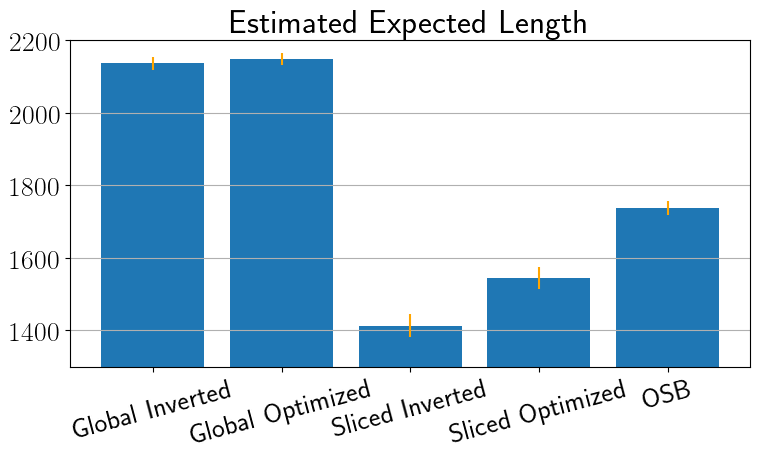

In [10]:
plt.figure(figsize=(8, 5))
plt.grid(True, axis='y')

plt.bar(x=np.arange(5), height=interval_lengths.mean(axis=0))
plt.vlines(
    x=np.arange(5),
    ymin=interval_lengths.mean(axis=0) - stats.norm.ppf(0.975) * (interval_lengths.std(axis=0) / np.sqrt(1000)),
    ymax=interval_lengths.mean(axis=0) + stats.norm.ppf(0.975) * (interval_lengths.std(axis=0) / np.sqrt(1000)),
    color='orange'
)

plt.xticks(ticks=np.arange(5), labels=[interval_type_key[i] for i in range(5)], rotation=15)
plt.title('Estimated Expected Length')
plt.ylim(1300, 2200)
plt.tight_layout()
plt.show()

#### Coverage

In [11]:
# compute coverage
coverage = np.zeros(shape=(ens_size, num_intervals))
for i in range(ens_size):
    for j in range(num_intervals):
        coverage[i, j] = int_cover(mu_true=mu_true, interval=intervals_inverted[i, j, :])
        
for i in range(num_intervals):
    print(f'{interval_type_key[i]}: Estimated Coverage: {coverage.mean(axis=0)[i]}')
    
    
coverage_cis = np.zeros(shape=(num_intervals, 2))
for i in range(num_intervals):
    coverage_cis[i, :] = proportion_confint(
        coverage.mean(axis=0)[i] * ens_size, ens_size, alpha=0.05, method='beta'
    )
print(coverage_cis)

Global Inverted: Estimated Coverage: 1.0
Global Optimized: Estimated Coverage: 1.0
Sliced Inverted: Estimated Coverage: 0.897
Sliced Optimized: Estimated Coverage: 0.931
OSB: Estimated Coverage: 0.995
[[0.99631792 1.        ]
 [0.99631792 1.        ]
 [0.87647707 0.91514863]
 [0.91348489 0.94592066]
 [0.98837053 0.99837458]]


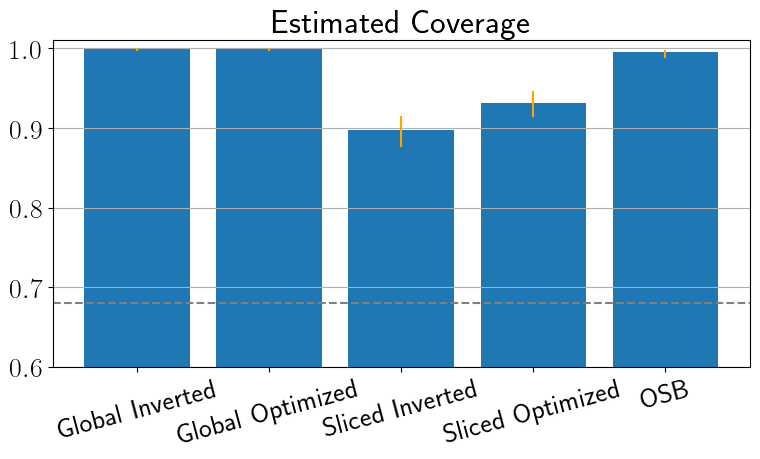

In [12]:
plt.figure(figsize=(8, 5))
plt.grid(True, axis='y')
plt.bar(x=np.arange(5), height=coverage.mean(axis=0))

plt.vlines(x=np.arange(5), ymin=coverage_cis[:, 0], ymax=coverage_cis[:, 1], color='orange')

plt.xticks(ticks=np.arange(5), labels=[interval_type_key[i] for i in range(5)], rotation=15)
plt.axhline(0.68, linestyle='--', color='gray')
plt.ylim(0.6, 1.01)
plt.title('Estimated Coverage')
plt.tight_layout()
plt.show()

# Adversarial Experiment Results

In [13]:
# true functional value -- please reach out to mcstanle@alumni.cmu.edu for source data
mu_true_adv = 1928.0136315444565

In [14]:
# set experiment index
EXP_IDX = 5

In [15]:
# set confidence levels
MCMC_PARAM_FP = f'./data/parameter_settings_mcmc/mcmc_parameters{EXP_IDX}.json'
with open(MCMC_PARAM_FP, 'rb') as f:
    mcmc_params = json.load(f)

ALPHA = mcmc_params["alpha"]
ETA = mcmc_params["eta"]
GAMMA = ALPHA - ETA
print(f'alpha = {ALPHA}')
print(f'eta   = {ETA}')
print(f'gamma = {GAMMA}')

alpha = 0.32
eta   = 0.01
gamma = 0.31


In [16]:
# read in interval files
NUM_FILES = 5
intervals_lst_adv = [None] * NUM_FILES

for i in range(NUM_FILES):
    with open(q_base_fp + f'/intervals{i}_func6_exp{EXP_IDX}_rolling_BBcalib.npy', 'rb') as f:
        intervals_lst_adv[i] = np.load(f)
        
# concatenate these together
intervals_inverted_adv = np.concatenate(intervals_lst_adv)
num_intervals_adv = intervals_inverted_adv.shape[1]
ens_size_adv = intervals_inverted_adv.shape[0]
print(intervals_inverted_adv.shape)

(1000, 5, 2)


#### Length

In [17]:
interval_lengths_adv = intervals_inverted_adv[:, :, 1] - intervals_inverted_adv[:, :, 0]

for i in range(num_intervals_adv):
    print(f'{interval_type_key[i]}: Estimated Length: {interval_lengths_adv.mean(axis=0)[i]}')

Global Inverted: Estimated Length: 2169.421023572588
Global Optimized: Estimated Length: 2185.124430977357
Sliced Inverted: Estimated Length: 1301.8329514885531
Sliced Optimized: Estimated Length: 1422.8909006682672
OSB: Estimated Length: 1605.9843626172344


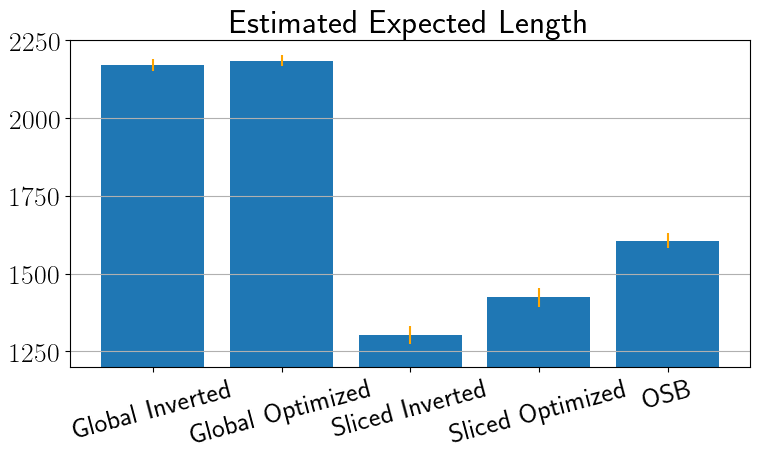

In [18]:
plt.figure(figsize=(8, 5))
plt.grid(True, axis='y')

plt.bar(x=np.arange(5), height=interval_lengths_adv.mean(axis=0))
plt.vlines(
    x=np.arange(5),
    ymin=interval_lengths_adv.mean(axis=0) - stats.norm.ppf(0.975) * (interval_lengths_adv.std(axis=0) / np.sqrt(1000)),
    ymax=interval_lengths_adv.mean(axis=0) + stats.norm.ppf(0.975) * (interval_lengths_adv.std(axis=0) / np.sqrt(1000)),
    color='orange'
)

plt.xticks(ticks=np.arange(5), labels=[interval_type_key[i] for i in range(5)], rotation=15)
plt.title('Estimated Expected Length')
plt.ylim(1200, 2250)
plt.tight_layout()
plt.show()

#### Coverage

In [19]:
# compute coverage
coverage_adv = np.zeros(shape=(ens_size_adv, num_intervals_adv))
for i in range(ens_size_adv):
    for j in range(num_intervals_adv):
        coverage_adv[i, j] = int_cover(mu_true=mu_true_adv, interval=intervals_inverted_adv[i, j, :])
        
for i in range(num_intervals_adv):
    print(f'{interval_type_key[i]}: Estimated Coverage: {coverage_adv.mean(axis=0)[i]}')
    
coverage_cis_adv = np.zeros(shape=(num_intervals_adv, 2))
for i in range(num_intervals_adv):
    coverage_cis_adv[i, :] = proportion_confint(
        coverage_adv.mean(axis=0)[i] * ens_size_adv, ens_size_adv, alpha=0.05, method='beta'
    )
print(coverage_cis_adv)

Global Inverted: Estimated Coverage: 0.869
Global Optimized: Estimated Coverage: 0.871
Sliced Inverted: Estimated Coverage: 0.672
Sliced Optimized: Estimated Coverage: 0.767
OSB: Estimated Coverage: 0.614
[[0.84649883 0.88930154]
 [0.84862858 0.89115943]
 [0.64192734 0.701056  ]
 [0.73953402 0.79288399]
 [0.5830267  0.6443    ]]


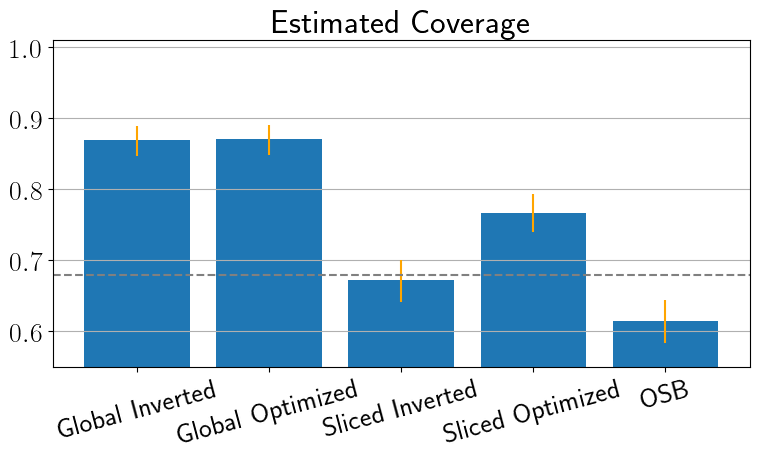

In [20]:
plt.figure(figsize=(8, 5))
plt.grid(True, axis='y')
plt.bar(x=np.arange(5), height=coverage_adv.mean(axis=0))

plt.vlines(x=np.arange(5), ymin=coverage_cis_adv[:, 0], ymax=coverage_cis_adv[:, 1], color='orange')

plt.xticks(ticks=np.arange(5), labels=[interval_type_key[i] for i in range(5)], rotation=15)
plt.axhline(0.68, linestyle='--', color='gray')
plt.ylim(0.55, 1.01)
plt.title('Estimated Coverage')
plt.tight_layout()
plt.show()